<a href="https://colab.research.google.com/github/Krithigha24/Reflector-Calibration-csv/blob/main/Reflector_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install circle-fit #WOAH YOU CAN JUST INSTALL WHATEVER LIBRARY U WANT IN PYTHON GOOGLE COLLAB

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from circle_fit import *
import numpy as np
from sklearn.cluster import DBSCAN
import plotly.express as px
from sklearn.metrics import silhouette_score as ss
import itertools
from collections import Counter
import math
import matplotlib.pyplot as plt
import statistics
import cv2
from google.colab.patches import cv2_imshow
from matplotlib.patches import Circle

In [ ]:
#########################################################################################################################################################################
#################### METHOD 1 ASSUMPTION: Within a scan, there is at least one laser beam that will intersect perpendicular to marker's surface #########################
#########################################################################################################################################################################
#CODE GENERAL STEPS:
#Given all the data points of the cylindrical marker, find the distance between each data points and the lidar (0,0)
#Add this as a new column to the dataframe and sort
#Pick a few of the shortest distance (the first few points)
#Find the average between the first few points
#Move radius distance from the average coordinate to the center coordinate of the circle
#Then you know the radius of the circle, and the center coordinates of the circle
# PLOT THE CIRCLE USING CIRCLE-FIT PLOT METHOD TO VISUALISE THE FIT OF THE SOLUTION WITH ALL THE DATA POINTS

pd.set_option('display.max_rows', 10)  # Display all rows
pd.set_option('display.max_columns', 10)  # Display all columns

#################################################################### METHOD 1 PARAMETERS ################################################################################
MARKER_DIST_TO_LIDAR1 = [212,303,505,707,909,1111] #DISTANCE IN MM OF THE EXPERIMENT MARKER FROM LIDAR : 212,303,505,707,909,1111 -> RECORD MORE ROSBAGS FOR MORE DISTANCES!!
NUM_NORMAL_POINTS1 = 2 # NUMBER OF CLOSESTS POINTS TO LIDAR TO AVERAGE
MARKER_RADIUS1 = 0.04225 #FIXED RADIUS OF CYLINDRICAL MARKER
DISTANCE_MEAN1 = []
DISTANCE_VARIANCE1 = []
################################################################### METHOD 1 COMMON FUNCTIONS ############################################################################
# Euclidian distance from point1 to point2, or from point1 to (0,0) if point2 input is not specified
def dist_point2point(point1, point2=(0, 0)):
    Px = (point1[0]-point2[0]) ** 2
    Py = (point1[1]-point2[1]) ** 2
    return math.sqrt(Px + Py)

def calculate_coordinates_on_line(start_point, end_point, distance, known_point):
    # Calculate the vector representing the line direction
    line_vector = np.array(end_point) - np.array(start_point)

    # Normalize the line vector
    normalized_vector = line_vector / np.linalg.norm(line_vector)

    # Calculate the coordinates of the desired point
    desired_point = known_point + (normalized_vector * distance)

    return desired_point
###########################################################################################################################################################################

for marker_dist_to_lidar1 in MARKER_DIST_TO_LIDAR1:
  #print(f"Processing {marker_dist_to_lidar1}")
  df1 = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/scan_data_{marker_dist_to_lidar1}.csv')

  TOTAL_NUM_SCANS1 = [num for num in range(df1['MSG_NO'].max() + 1)]

  # Calculate Euclidean distance of each data point to coordinates of lidar (0,0)
  df1['DIST TO LIDAR'] = np.sqrt(df1['X_COORD']**2 + df1['Y_COORD']**2)

  DISTANCE_ERRORS1 = []  # LIST TO STORE DISTANCE ERROR FROM EACH PROCESSED SCAN

  for SCAN_NUMBER1 in TOTAL_NUM_SCANS1:
    # Filter the DATA FRAME depending on which 'MSG_NO' chosen
    filtered_df1 = df1[df1['MSG_NO'] == SCAN_NUMBER1]

    #Select the 'X_COORD' and 'Y_COORD' coordinates columns
    xy1 = filtered_df1[['X_COORD', 'Y_COORD']]
    xy1 = xy1.to_numpy()

    #FOCUS ON COLUMN X_COORD, Y_COORD AND DIST TO LIDAR.
    #SORT THE DATAFRAME ACCORDING TO SMALLEST TO LARGEST VALUE OF DIST TO LIDAR COLUMN
    sorted_df1 = filtered_df1.sort_values(by='DIST TO LIDAR')

    # Find the average between the first few points
    coordinates_subset1 = sorted_df1[['X_COORD', 'Y_COORD']].head(NUM_NORMAL_POINTS1)  # Extract first 5 values from 'x' and 'y' columns
    average_x1 = coordinates_subset1['X_COORD'].mean()  # Compute average of 'x' values
    average_y1 = coordinates_subset1['Y_COORD'].mean()  # Compute average of 'y' values

    average_point1 = (average_x1, average_y1)  # Average (x, y) coordinate point

    # Example usage
    start_point1 = (0, 0)
    end_point1 = average_point1
    distance1 = MARKER_RADIUS1
    known_point1 = average_point1

    center_coordinates1 = calculate_coordinates_on_line(start_point1, end_point1, distance1, known_point1)
    computed_marker_dist1 = dist_point2point(center_coordinates1)
    distance_error1 = computed_marker_dist1 - marker_dist_to_lidar1/1000.0
    DISTANCE_ERRORS1.append(distance_error1)

  DISTANCE_MEAN1.append(np.mean(DISTANCE_ERRORS1))
  DISTANCE_VARIANCE1.append(np.var(DISTANCE_ERRORS1))

In [ ]:
#########################################################################################################################################################################
#################################### METHOD 2: FINDING OUT WHICH CIRCLE FIT ALGORITHM IS MOST ACCURATE FOR OUR APPLICATION ##############################################
#########################################################################################################################################################################
# NEEEEEEEED TO REEEEEEEEEEELY IMPORVE THISSSSSSSSSSSSSSS :(
#################################################################### METHOD 2 PARAMETERS ################################################################################
MARKER_DIST_TO_LIDAR2 = [212,303,505,707,909,1111] #DISTANCE IN MM OF THE EXPERIMENT MARKER FROM LIDAR : 212,303,505,707,909,1111 -> RECORD MORE ROSBAGS FOR MORE DISTANCES!!
ALGO_NAME2 = 'hyperSVD' #hyperLSQ(), standardLSQ(), riemannSWFLa(), prattSVD(), taubinSVD(), hyperSVD(), kmh()
DISTANCE_MEAN2 = []
DISTANCE_VARIANCE2 = []
###########################################################################################################################################################################

for marker_dist_to_lidar2 in MARKER_DIST_TO_LIDAR2:
  #print(f"Processing {marker_dist_to_lidar2}")
  df2 = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/scan_data_{marker_dist_to_lidar2}.csv')

  TOTAL_NUM_SCANS2 = [num for num in range(df2['MSG_NO'].max() + 1)]

  DISTANCE_ERRORS2 = []  # LIST TO STORE DISTANCE ERROR FROM EACH PROCESSED SCAN

  for SCAN_NUMBER2 in TOTAL_NUM_SCANS2:
    # Filter the DATA FRAME depending on which 'MSG_NO' chosen
    filtered_df2 = df2[df2['MSG_NO'] == SCAN_NUMBER2]

    #Select the 'X_COORD' and 'Y_COORD' coordinates columns
    xy2 = filtered_df2[['X_COORD', 'Y_COORD']]
    xy2 = xy2.to_numpy()

    if ALGO_NAME2 == 'hyperLSQ':
      xc2, yc2, r2, sigma2 = hyperLSQ(xy2)
    elif ALGO_NAME2 == 'standardLSQ':
      xc2, yc2, r2, sigma2 = standardLSQ(xy2)
    elif ALGO_NAME2 == 'riemannSWFLa':
      xc2, yc2, r2, sigma2 = riemannSWFLa(xy2)
    elif ALGO_NAME2 == 'prattSVD':
      xc2, yc2, r2, sigma2 = prattSVD(xy2)
    elif ALGO_NAME2 == 'taubinSVD':
      xc2, yc2, r2, sigma2 = taubinSVD(xy2)
    elif ALGO_NAME2 == 'hyperSVD':
      xc2, yc2, r2, sigma2 = hyperSVD(xy2)
    elif ALGO_NAME2 == 'kmh':
      xc2, yc2, r2, sigma2 = kmh(xy2)

    center_coordinates2 = (xc2,yc2)
    computed_marker_dist2 = dist_point2point(center_coordinates2)
    distance_error2 = computed_marker_dist2 - marker_dist_to_lidar2/1000.0
    DISTANCE_ERRORS2.append(distance_error2)

  DISTANCE_MEAN2.append(np.mean(DISTANCE_ERRORS2))
  DISTANCE_VARIANCE2.append(np.var(DISTANCE_ERRORS2))

In [ ]:
# plt.scatter(MARKER_DIST_TO_LIDAR1, DISTANCE_MEAN1, s=10)
# plt.xlabel('Distance to Lidar')
# plt.ylabel('Error Mean')
# plt.title(f'METHOD1')
# plt.show()
# plt.scatter(MARKER_DIST_TO_LIDAR2, DISTANCE_MEAN2, s=10)
# plt.xlabel('Distance to Lidar')
# plt.ylabel('Error Mean')
# plt.title(f'METHOD2')
# #plt.ylim(-0.005, 0.005)
# plt.show()

In [ ]:
# plt.scatter(MARKER_DIST_TO_LIDAR1, DISTANCE_VARIANCE1, s=10)
# plt.xlabel('Distance to Lidar')
# plt.ylabel('Error Variance')
# plt.title(f'METHOD1')
# plt.show()
# plt.scatter(MARKER_DIST_TO_LIDAR2, DISTANCE_VARIANCE2, s=10)
# plt.xlabel('Distance to Lidar')
# plt.ylabel('Error Variance')
# #plt.ylim(-0.1, 0.1)
# plt.title(f'METHOD2')
# plt.show()

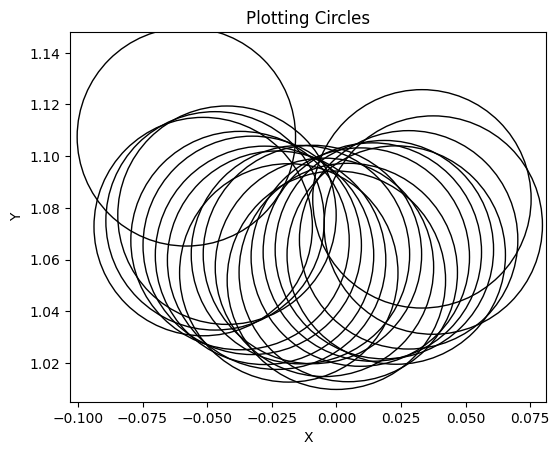

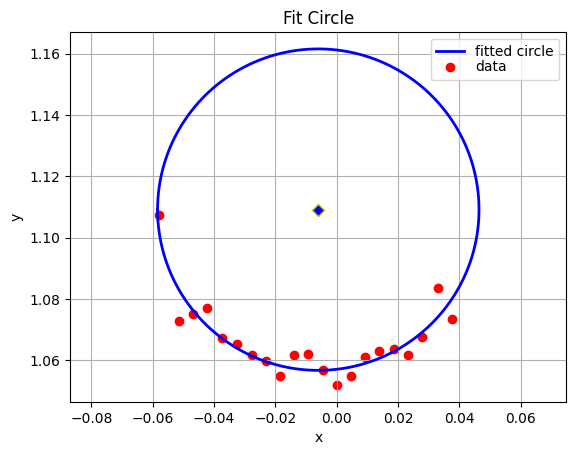

Computed center of coordinates is : (-0.006022826509179194, 1.1091628098954138)
Radius of the circle is: 0.05241339148571413
The error in radius of marker is: 0.01016339148571413
Computed distance between marker at 1111 and lidar : 1.1091791619455578
The error in distance computation is -0.0018208380544422198


In [ ]:
###################################################################################################################################################################
################TRIED TO DO CIRCLE HOUGH TRANSFORM BUT JUST DID A BUNCH OF MURUKKU AND JEELEBI. IDK WHAT ELSE TO DO :(#############################################
###################################################################################################################################################################

MARKER_RADIUS = 0.04225 #FIXED RADIUS OF CYLINDRICAL REFLECTOR
MARKER_DIST_TO_LIDAR = 1111 #DISTANCE IN MM OF THE EXPERIMENT MARKER FROM LIDAR : 212,303,505,707,909,1111
SCAN_NUMBER = 4
df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/scan_data_{MARKER_DIST_TO_LIDAR}.csv')

filtered_df = df[df['MSG_NO'] == SCAN_NUMBER]
xy = filtered_df[['X_COORD', 'Y_COORD']].to_numpy()
center_coordinates = xy.tolist()

# Define the center coordinates and radii for the circles
radii = [MARKER_RADIUS] * len(center_coordinates)

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot each circle
for center, radius in zip(center_coordinates, radii):
    circle = Circle(center, radius, edgecolor='black', facecolor='none')
    ax.add_patch(circle)

# Set the x-axis and y-axis limits
# ax.set_xlim(0.16, 0.30)
# ax.set_ylim(-0.06, 0.06)
ax.set_xlim(-0.103, 0.081)
ax.set_ylim(1.005, 1.148)
# ax.set_xlim(-0.025, 0.012)
# ax.set_ylim(1.083, 1.11)
# Set the aspect ratio to equal so the circles are circular
ax.set_aspect('equal')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plotting Circles')

# Show the plot
plt.show()

xc, yc, r, sigma = kmh(xy)
plot_data_circle(xy, xc, yc,r)

print("Computed center of coordinates is :", (xc,yc))
print("Radius of the circle is:", r)
radius_error = r - MARKER_RADIUS
print("The error in radius of marker is:", radius_error)
marker_dist_to_lidar = dist_point2point((xc,yc))
print(f"Computed distance between marker at {MARKER_DIST_TO_LIDAR} and lidar : {marker_dist_to_lidar}")
distance_error = marker_dist_to_lidar - MARKER_DIST_TO_LIDAR/1000.0
print(f"The error in distance computation is {distance_error}")

[[ 3.75867976e-02  1.07634394e+00]
 [ 3.29510946e-02  1.07849674e+00]
 [ 2.82973194e-02  1.08062954e+00]
 [ 2.32765216e-02  1.06674611e+00]
 [ 1.86392081e-02  1.06783730e+00]
 [ 1.39273684e-02  1.06390885e+00]
 [ 9.27634552e-03  1.06295949e+00]
 [ 4.62514612e-03  1.05998985e+00]
 [ 3.82742354e-08  1.05200005e+00]
 [-4.59888969e-03  1.05398999e+00]
 [-9.25008849e-03  1.05995958e+00]
 [-1.38749319e-02  1.05990913e+00]
 [-1.83424408e-02  1.05083993e+00]
 [-2.30364799e-02  1.05574870e+00]
 [-2.76428186e-02  1.05563813e+00]
 [-3.29204762e-02  1.07749716e+00]
 [-3.76914184e-02  1.07934214e+00]
 [-4.22435213e-02  1.07517042e+00]
 [-4.75014723e-02  1.08796350e+00]
 [-5.15764510e-02  1.07376206e+00]
 [-5.77788537e-02  1.10248698e+00]]


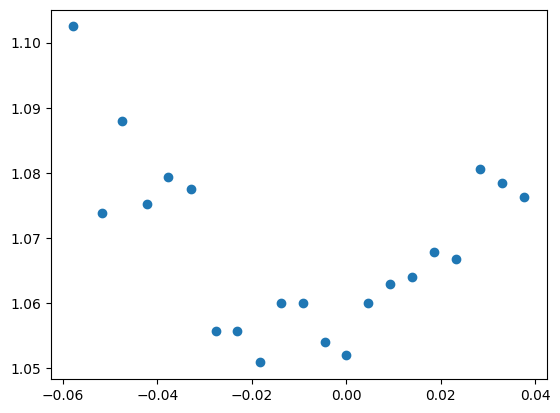

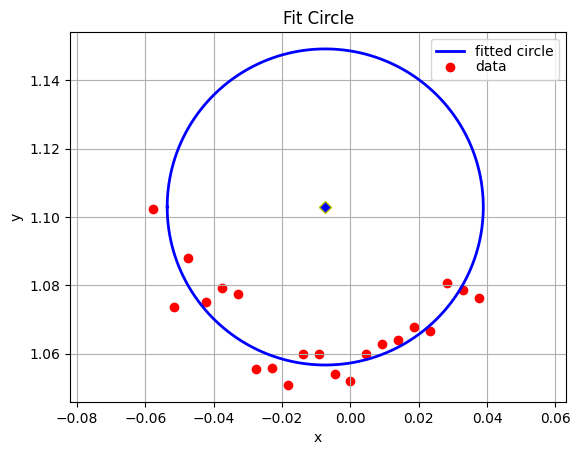

Computed center of coordinates is : (-0.007367827717993372, 1.1029381471162956)
Radius of the circle is: 0.04626910912643218
The error in radius of marker is: 0.004019109126432177
Computed distance between marker at 1111 and lidar : 1.1029627560573427
The error in distance computation is -0.008037243942657257


In [ ]:
############################################### METHOD 2 PARAMETERS ################################################################

MARKER_RADIUS = 0.04225 #FIXED RADIUS OF CYLINDRICAL REFLECTOR
MARKER_DIST_TO_LIDAR = 1111 #DISTANCE IN MM OF THE EXPERIMENT MARKER FROM LIDAR : 212,303,505,707,909,1111
SCAN_NUMBER = 12
df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/scan_data_{MARKER_DIST_TO_LIDAR}.csv')

filtered_df = df[df['MSG_NO'] == SCAN_NUMBER]
xy = filtered_df[['X_COORD', 'Y_COORD']]
xy = xy.to_numpy()

print(xy)
# Remove first four and last four elements
#xy = xy[5:-5]

# Access the x and y values in 'X_COORD' and 'Y_COORD' column
x,y = filtered_df.X_COORD, filtered_df.Y_COORD

plt.scatter(x,y)

xc, yc, r, sigma = kmh(xy)
plot_data_circle(xy, xc, yc,r)

print("Computed center of coordinates is :", (xc,yc))
print("Radius of the circle is:", r)
radius_error = r - MARKER_RADIUS
print("The error in radius of marker is:", radius_error)
marker_dist_to_lidar = dist_point2point((xc,yc))
print(f"Computed distance between marker at {MARKER_DIST_TO_LIDAR} and lidar : {marker_dist_to_lidar}")
distance_error = marker_dist_to_lidar - MARKER_DIST_TO_LIDAR/1000.0
print(f"The error in distance computation is {distance_error}")


In [ ]:
# ##############################################################################################################################################################################################
# ######################## METHOD 3: POINT OF INTERSECTION OF PERPENDICULAR BISECTOR OF TWO UNPARALLEL CHORDS OF CIRCLE GIVES CENTER COORDINATES OF CIRCLE #####################################
# ##############################################################################################################################################################################################

#######################################################  I THINK CAN TRY APPLYING DBSCAN TO THIS METHOD TO TRY TO SALVAGE IT ###################################################################

# ################################################ METHOD 3 PARAMETERS #########################################################################################################################
# MARKER_DIST_TO_LIDAR3 = 1111 #DISTANCE IN MM OF THE EXPERIMENT MARKER FROM LIDAR : 212,303,505,707,909,1111
# SCAN_NUMBER3 = 231
# ################################################ METHOD 3 FUNCTIONS ##########################################################################################################################
# def perpendicular_bisector(p1, p2):
#     # Calculate the midpoint of the two points
#     midpoint = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

#     # Calculate the slope of the line passing through the two points
#     slope = (p2[1] - p1[1]) / (p2[0] - p1[0])

#     # Calculate the negative reciprocal of the slope to get the slope of the perpendicular bisector
#     perp_slope = -1 / slope

#     # Calculate the y-intercept of the perpendicular bisector line
#     y_intercept = midpoint[1] - perp_slope * midpoint[0]

#     # Return the equation of the perpendicular bisector in the form of y = mx + c
#     return (perp_slope, y_intercept)

# def find_intersection(line1, line2):
#     # Unpack the slope-intercept values of the first line
#     m1, c1 = line1

#     # Unpack the slope-intercept values of the second line
#     m2, c2 = line2

#     # Calculate the x-coordinate of the intersection point
#     x = (c2 - c1) / (m1 - m2)

#     # Calculate the y-coordinate of the intersection point
#     y = m1 * x + c1

#     # Return the coordinate of the intersection point
#     return (x, y)
# ############################################################################################################################################################################################

# df3 = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/scan_data_{MARKER_DIST_TO_LIDAR3}.csv')

# filtered_df3 = df3[df3['MSG_NO'] == SCAN_NUMBER3]
# xy3 = filtered_df3[['X_COORD', 'Y_COORD']]
# xy3 = xy3.to_numpy()

# # STEP 1 - ELIMINATE THE END TWO POINTS OF THE ARC
# xy3 = xy3[1:-1]

# # STEP 2 - GET NUMBER OF DATA POINTS WE ARE DEALING WITH AND CREATE AN ARRAY FROM 0 TO NUM_DATA_POINTS
# numbered_points3 = [num for num in range(0,len(xy3))]

# # STEP 3 - GENERATE ALL COMBINATIONS OF 2 FROM THE NUMBERING
# combinations3 = list(itertools.combinations(numbered_points3, 2))

# # STEP 4 - GET ALL VALID PAIRS
# valid_pairs3 = []

# for i in range(len(combinations3)):
#   for j in range(i+1, len(combinations3)):
#     if (combinations3[i][0] - combinations3[j][0])*(combinations3[i][1] - combinations3[j][1]) < 0:
#         continue
#     valid_pairs3.append([combinations3[i],combinations3[j]])

# # STEP 6 - KEEP TRACK OF CENTER COORDINATES OF CIRCLE
# CENTER_COORD3 = []

# # STEP 7 - ITERATE OVER EACH ELEMENT OF VALID_PAIRS3[] ARRAY
# for index, item in enumerate(valid_pairs3):
#   # STEP 8 - GET COORDINATES OF THE 4 POINTS THAT WILL FORM THE TWO NON-PARALLEL ARCS
#   id1 = valid_pairs3[index][0][0]
#   id2 = valid_pairs3[index][0][1]
#   id3 = valid_pairs3[index][1][0]
#   id4 = valid_pairs3[index][1][1]

#   # STEP 9 - 2 POINTS WILL FORM ARC 1, PERPENDICULAR BISECTOR OF THE FIRST ARC
#   p1 = xy3[id1]
#   p2 = xy3[id2]
#   first_line3 = perpendicular_bisector(p1, p2)

#   # STEP 10 - 2 POINTS WILL FORM ARC 2, PERPENDICULAR BISECTOR OF THE SECOND ARC
#   p3 = xy3[id3]
#   p4 = xy3[id4]
#   second_line3 = perpendicular_bisector(p3, p4)

#   # STEP 11 - GET POINT OF INTERSECTION OF THE TWO LINES AND STORE THE SOLUTION IN ANOTHER LIST
#   center_coord3 = find_intersection(first_line3,second_line3)
#   CENTER_COORD3.append(center_coord3)


# # #STEP 12 - PRINT OUT THE CENTER_COORD3 SOLUTION LIST
# # print(len(CENTER_COORD3))

# # Extract x and y values from the coordinates
# x_values = [coord[0] for coord in CENTER_COORD3]
# y_values = [coord[1] for coord in CENTER_COORD3]

# # Plot the coordinates


# # plt.ylim(-10, 10)
# # plt.xlim(-5, 5)
# # plt.ylim(0.0, 2.5)
# # plt.xlim(-1, 1)
# # plt.ylim(0.75, 1.25)
# # plt.xlim(-0.25, 0.25)
# # plt.ylim(1.05, 1.2)
# # plt.xlim(-0.1, 0.1)
# # plt.ylim(1.05, 1.15)
# # plt.xlim(-0.025, 0.025)
# # plt.ylim(1.09, 1.11)
# # plt.xlim(-0.01, 0.0)
# plt.scatter(x_values,y_values, s=1)